# *Identificador de tênis da nike e adidas*

## Autor:
#### Nome: João Gabriel Elvas Ribeiro
#### Matricula: 190109599
#### Github: JoaoGElvas

## Objetivo:
#### Conseguir distinguir um tênis da nike e da adidas.

## Preparando o ambiente: 
#### Primeiro iremos instalar o duckduckgo_search para podermos encontrar as URLS de imagens.
#### Após isso iremos instalar a biblioteca do fastai.

In [ ]:
pip install -U duckduckgo_search

In [ ]:
pip install fastai

## Obtendo as primeiras imagens 

#### Será utilizado o duckduckgo para encontrarmos as primeiras imagens

In [43]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Será utilizado o fastdownload para realizar o download de imagens.

In [44]:
urls = search_images('nikesneakers', max_images=1)
urls[0]

Searching for 'nikesneakers'


'https://worthly.com/wp-content/uploads/2014/11/139517568.jpg'

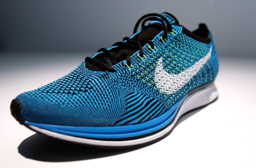

In [45]:
from fastdownload import download_url
dest = 'nikesneakers.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### Temos nossa primeira imagem de um tênis da nike.

Searching for 'adidassneakers'


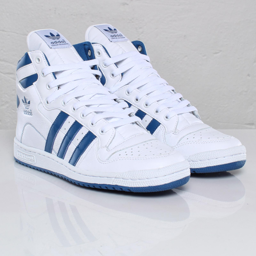

In [46]:
download_url(search_images('adidassneakers', max_images=1)[0], 'adidassneakers.jpg', show_progress=False)
Image.open('adidassneakers.jpg').to_thumb(256,256)

#### Temos nossa primeira imagem de um tênis da adidas.

#### A seguri iremos utilizar o código abaixo para realizar o dowload de alguns grupos de imagens para treinamento: 
* Foto de tênis da nike
* Foto de tênis da nike no sol
* Foto de tênis da nike na sombra
* Foto de tênis da adidas
* Foto de tênis da adidas no sol
* Foto de tênis da adidas na sombra

#### Obs: O comando *sleep(10)* é utilizado para gerar uma pausa entre as pesquisas, assim evitando sobrecarregar o servidor

In [47]:
searches = 'nikesneakers','adidassneakers'
path = Path('nikesneakers_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'nikesneakers photo'
Searching for 'nikesneakers sun photo'
Searching for 'nikesneakers shade photo'
Searching for 'adidassneakers photo'
Searching for 'adidassneakers sun photo'
Searching for 'adidassneakers shade photo'


In [48]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

#### Nessa etapa acima foi verificado se as imagens foram baixadas corretamente, as que apresentarem problemas serão excluídas.

#### A fim de desenvolver um modelo para realizar previsões, é preciso contar com os DataLoaders. DataLoaders são objetos que têm um conjunto de treinamento (imagens utilizadas para construir o modelo) e um conjunto de validação (imagens empregadas para avaliar a acurácia do modelo).

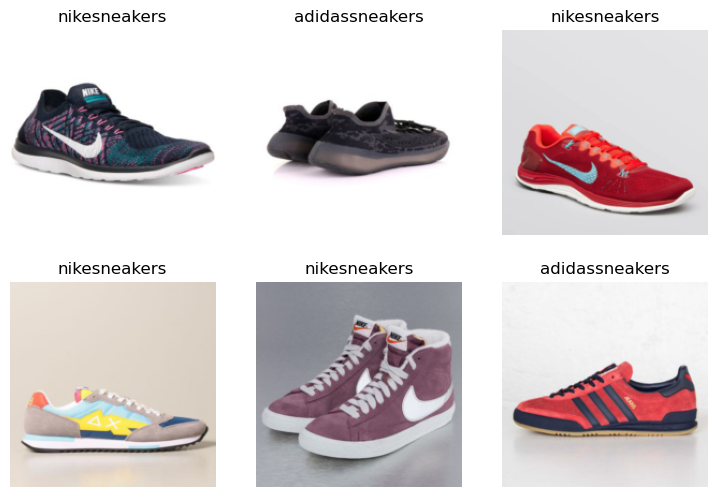

In [65]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

#### Parâmetros utilizados:

##### blocks: Como estamos utilizando imagens como inputs é neccesario utilizar o ImageBlocks. Já nossos outputs são categorias.

##### get-items: A função get_image_files é utilizada para encontrarmos os nossos inputs.

##### splitter: Com a finalidade de treinar melhor nosso programa vamos dividir os dades em treinamento e validação. O comando splitter tem essa função. Neste caso, estamos dividindo em 20% para validação e não serão usados dados no treinamento.

##### get_y: Utilizado para vincular cada imagem com um rotulo correspondente à pasta em que está localizada.

##### item_tfms: Essa operação irá redimensionar as imagens para 192 pixels, utilizando o método "squish". Que seria algo com esmagar a imagem.

## Treinando o modelo

### Treinando o modelo com Resnet18

In [50]:
learnResnet18 = vision_learner(dls, resnet18, metrics=error_rate)
learnResnet18.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.128967,0.542226,0.223881,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.457957,0.236404,0.119403,00:47
1,0.326438,0.042757,0.029851,00:46
2,0.248836,0.028943,0.014925,00:47


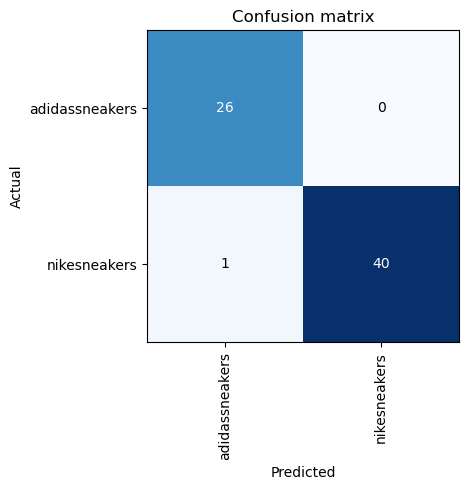

In [51]:
matriz = ClassificationInterpretation.from_learner(learnResnet18)
matriz.plot_confusion_matrix()

### Treinando o modelo com Resnet34

In [52]:
learnResnet34 = vision_learner(dls, resnet34, metrics=error_rate)
learnResnet34.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.143151,0.651925,0.283582,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.505950,0.070465,0.029851,01:24
1,0.397205,0.166400,0.044776,01:24
2,0.308203,0.117538,0.014925,01:25


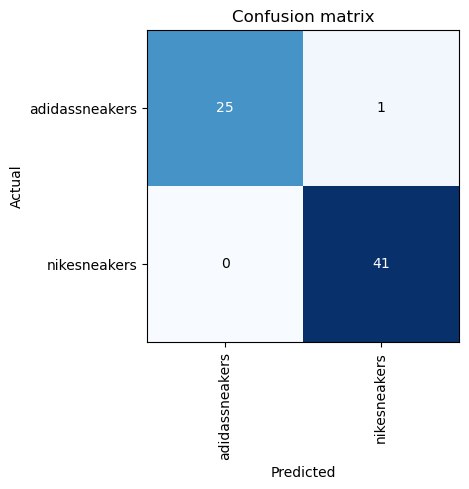

In [53]:
matriz = ClassificationInterpretation.from_learner(learnResnet34)
matriz.plot_confusion_matrix()

### Treinando o modelo com Resnet50

In [56]:
learnResnet50 = vision_learner(dls, resnet50, metrics=error_rate)
learnResnet50.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.814388,0.290771,0.044776,01:20


epoch,train_loss,valid_loss,error_rate,time
0,0.431793,0.540269,0.179104,01:50
1,0.344587,0.043078,0.014925,01:51
2,0.306188,0.052686,0.014925,01:50


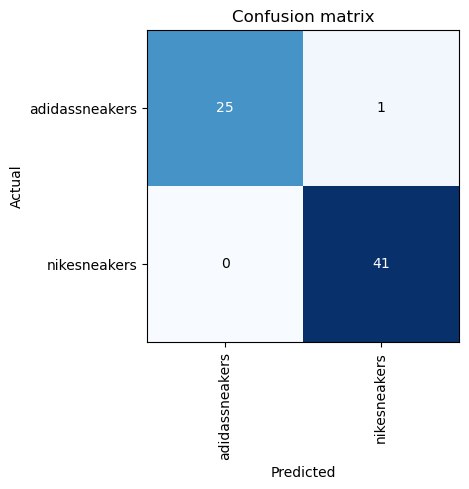

In [57]:
matriz = ClassificationInterpretation.from_learner(learnResnet50)
matriz.plot_confusion_matrix()

## Análise do treinamento

### Levando em consideração o error_rate a rede com o melhor resultado foi a resnet18 que entre as redes da familia resnet foi a que conseguiu chegar no valor de 0.119403. Mas podemos levar em consideração que as outas duas (34 e 50) foram muito bem, chegando em um resultado de 0.014.

### As redes podem se comportar de forma diferente para cada novo problema, por isso é interessante testar diferentes redes enquanto está criando o seu modelo.

## Deployment

In [76]:
learn.export('model.pkl')

Neste link do HuggingFace poderemos encontrar o aplicativo/website criado com o gradio nesse artigo.
https://huggingface.co/spaces/JoaoElvas/NikexAdidas

## Conclusão
Apesar dos 2 serem tênis, o que teoricamente dificultaria a distinção, a aplicação teve uma faciliadade muito grande de distinguir. Por isso nosso programa teve uma taxa de erro de 0.01. Mostrando que o programa tem uma taxa de erro que não é quase nada expressiva.